In [17]:
#!pip install requests
#!pip install nba_api
#!pip install imblearn

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from imblearn.over_sampling import SMOTE
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.endpoints import leaguestandings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from bs4 import BeautifulSoup

## Webscraping Basketball Reference

In [20]:
def scrape_NBA_team_data(years=[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]):
    final_df = pd.DataFrame(columns=["Year", "Rk", "Team", "Conf", "Div",
                                      "W", "L", "W/L%", "MOV", "ORtg", "DRtg",
                                      "NRtg", "MOV/A", "ORtg/A", "DRtg/A", "NRtg/A"])

    for i in years:
        url = f"https://www.basketball-reference.com/leagues/NBA_{i}_ratings.html"
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            table = soup.find('table', {'id': 'ratings'})

            if table:
                # Extract data from the table
                data = []
                for row in table.find_all('tr')[2:]:
                    columns = row.find_all(['th', 'td'])
                    row_data = [col.text.strip() for col in columns]
                    data.append(row_data)

                # Create a DataFrame for the current year
                year_df = pd.DataFrame(data, columns=final_df.columns[1:])
                year_df.insert(0, "Year", str(i-1) + "-" + str(i%100))

                # Concatenate the data to the final DataFrame
                final_df = pd.concat([final_df, year_df], ignore_index=True)

            else:
                print(f"Table with ID 'ratings' not found on the page for year {i}.")
        else:
            print(f"Failed to retrieve the page for year {i}. Status code: {response.status_code}")

    return final_df 

In [21]:
def scrape_advanced_stats(years):
    final_df = pd.DataFrame()  # Initialize an empty DataFrame to store the results

    for i in years:
        url = f"https://www.basketball-reference.com/leagues/NBA_{i}.html"
        response = requests.get(url)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find the table with id 'advanced_stats'
            table = soup.find('table', {'id': 'advanced-team'})

            if table:
                # Create a DataFrame
                year_df = pd.read_html(str(table))[0]
                year_df.insert(0, "Year", str(i-1) + "-" + str(i%100))

                final_df = pd.concat([final_df, year_df], ignore_index=True)

            else:
                print("Table with ID 'advanced_stats' not found on the page.")
        else:
            print(f"Failed to retrieve the page. Status code: {response.status_code}")
            
    return final_df

In [22]:
team_adv_stats = scrape_advanced_stats(years=[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
team_adv_stats_2024 = scrape_advanced_stats(years=[2024])

In [23]:
team_adv_stats.columns = team_adv_stats.columns.get_level_values(1)
team_adv_stats.columns.values[0]="Year"
team_adv_stats = team_adv_stats.drop(["Unnamed: 17_level_1", "Unnamed: 22_level_1", "Unnamed: 27_level_1", "Arena", "Attend.","Attend./G"], axis=1)
team_adv_stats = team_adv_stats[team_adv_stats["Team"] != "League Average"]
team_adv_stats['Team'] = team_adv_stats['Team'].str.rstrip('*')

In [24]:
team_adv_stats_2024.columns = team_adv_stats_2024.columns.droplevel(0)
team_adv_stats_2024.columns.values[0] = 'Year'
team_adv_stats_2024 = team_adv_stats_2024.drop(["Unnamed: 17_level_1", "Unnamed: 22_level_1", "Unnamed: 27_level_1", "Arena", "Attend.","Attend./G"], axis=1)
team_adv_stats_2024 = team_adv_stats_2024[team_adv_stats_2024["Team"] != "League Average"]

In [25]:
pd.set_option('display.max_columns', None)
team_adv_stats

,Year,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%,TOV%,DRB%,FT/FGA
0,2014-15,1.0,Golden State Warriors,26.6,67.0,15.0,65,17,10.10,-0.09,10.01,111.6,101.4,10.2,98.3,0.239,0.311,0.571,0.540,13.1,24.1,0.184,0.470,14.3,74.5,0.217
1,2014-15,2.0,Los Angeles Clippers,28.8,56.0,26.0,58,24,6.59,0.22,6.80,112.4,105.5,6.9,94.7,0.303,0.322,0.565,0.533,11.6,22.8,0.215,0.493,13.2,75.7,0.231
2,2014-15,3.0,San Antonio Spurs,29.8,55.0,27.0,58,24,6.20,0.14,6.34,108.5,102.0,6.5,93.8,0.256,0.269,0.555,0.517,13.1,23.4,0.200,0.484,13.3,77.3,0.190
3,2014-15,4.0,Atlanta Hawks,27.8,60.0,22.0,56,26,5.43,-0.68,4.75,108.9,103.1,5.8,93.9,0.259,0.321,0.563,0.527,13.5,21.4,0.201,0.492,14.9,73.4,0.185
4,2014-15,5.0,Cleveland Cavaliers,26.9,53.0,29.0,53,29,4.48,-0.40,4.08,111.1,106.3,4.8,92.3,0.287,0.334,0.557,0.520,13.4,26.8,0.216,0.502,12.6,74.7,0.177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2022-23,26.0,Portland Trail Blazers,25.1,33.0,49.0,31,51,-4.01,0.05,-3.96,114.8,118.8,-4.0,98.6,0.289,0.413,0.589,0.549,13.1,22.4,0.230,0.563,12.1,74.9,0.217
274,2022-23,27.0,Charlotte Hornets,25.3,27.0,55.0,26,56,-6.24,0.35,-5.89,109.2,115.3,-6.1,100.8,0.261,0.360,0.550,0.516,12.3,23.8,0.195,0.544,12.5,75.5,0.211
275,2022-23,28.0,Houston Rockets,22.1,22.0,60.0,23,59,-7.85,0.24,-7.62,111.4,119.3,-7.9,99.0,0.285,0.359,0.554,0.516,14.0,30.2,0.215,0.564,11.8,75.8,0.218
276,2022-23,29.0,Detroit Pistons,24.1,17.0,65.0,22,60,-8.22,0.49,-7.73,110.7,118.9,-8.2,99.0,0.295,0.372,0.561,0.520,13.3,24.9,0.227,0.557,11.9,74.0,0.231


In [26]:
team_adv_stats_2024 

,Year,Rk,Team,Age,W,L,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%,TOV%,DRB%,FT/FGA
0,2023-24,1.0,Boston Celtics,28.4,28.0,7.0,28,7,10.80,0.38,11.18,121.6,110.7,10.9,98.2,0.245,0.475,0.603,0.570,11.7,26.1,0.196,0.522,11.0,76.5,0.154
1,2023-24,2.0,Philadelphia 76ers,28.5,23.0,12.0,26,9,8.23,-0.71,7.52,119.9,111.7,8.2,99.4,0.302,0.362,0.591,0.543,11.1,25.4,0.253,0.529,13.2,74.9,0.216
2,2023-24,3.0,Oklahoma City Thunder,23.1,23.0,11.0,24,10,7.56,0.73,8.29,120.6,113.1,7.5,100.4,0.256,0.375,0.614,0.576,11.3,20.2,0.215,0.523,13.8,70.8,0.223
3,2023-24,4.0,Minnesota Timberwolves,27.4,25.0,9.0,23,11,5.65,0.71,6.35,114.4,108.7,5.7,98.6,0.288,0.375,0.596,0.557,14.0,23.4,0.229,0.509,12.7,76.8,0.192
4,2023-24,5.0,Denver Nuggets,26.9,25.0,12.0,24,13,5.11,0.26,5.37,118.9,113.6,5.3,97.3,0.227,0.354,0.585,0.559,11.0,25.7,0.170,0.528,11.4,75.4,0.206
5,2023-24,6.0,Los Angeles Clippers,30.6,22.0,12.0,22,12,5.26,-0.45,4.81,119.1,113.8,5.3,97.9,0.269,0.380,0.601,0.563,12.2,25.3,0.218,0.528,12.0,74.8,0.203
6,2023-24,7.0,Milwaukee Bucks,29.9,25.0,11.0,23,13,4.78,-1.05,3.73,121.1,116.5,4.6,102.1,0.302,0.420,0.614,0.579,11.7,22.7,0.235,0.531,10.4,75.2,0.199
7,2023-24,8.0,New York Knicks,26.2,21.0,15.0,22,14,3.33,0.31,3.65,118.6,115.2,3.4,97.6,0.274,0.388,0.577,0.540,11.7,29.0,0.213,0.552,12.2,76.5,0.186
8,2023-24,9.0,New Orleans Pelicans,25.7,21.0,15.0,22,14,3.36,-0.29,3.07,116.1,112.7,3.4,99.0,0.287,0.352,0.583,0.547,12.1,25.2,0.220,0.535,12.9,76.0,0.202
9,2023-24,10.0,Houston Rockets,25.2,18.0,16.0,20,14,2.59,0.32,2.91,113.8,111.2,2.6,98.2,0.266,0.385,0.572,0.535,11.7,23.2,0.207,0.518,11.9,76.8,0.231


## NBA API Data

In [27]:
nba_teams = teams.get_teams()
team_ids = [team.get("id") for team in nba_teams]
team_data = [teamyearbyyearstats.TeamYearByYearStats(team_id=num) for num in team_ids] # produces a list of dfs

In [28]:
beyond_2014_team_data = [team_data[i].get_data_frames()[0].tail(10).head(9) for i in range(len(team_data))] # combine all dfs and get only years 2014-2022
team_data_2024 = [team_data[i].get_data_frames()[0].tail(1) for i in range(len(team_data))]

In [39]:
#Cleaning beyond_2014_comb df
beyond_2014_team_data_comb = pd.concat(beyond_2014_team_data, ignore_index=True)
finals_mapper = {"N/A": 0, "FINALS APPEARANCE": 1, "LEAGUE CHAMPION": 2}

beyond_2014_team_data_comb["NBA_FINALS_APPEARANCE"] = beyond_2014_team_data_comb['NBA_FINALS_APPEARANCE'].replace(finals_mapper)
beyond_2014_team_data_comb.insert(0, "TEAM", beyond_2014_team_data_comb["TEAM_CITY"] + " " + beyond_2014_team_data_comb["TEAM_NAME"])
beyond_2014_team_data_comb = beyond_2014_team_data_comb.drop(["TEAM_ID", "CONF_COUNT", "DIV_COUNT"], axis=1)
beyond_2014_team_data_comb["TEAM"] = beyond_2014_team_data_comb["TEAM"].replace("LA Clippers", "Los Angeles Clippers")

In [40]:
beyond_2014_team_data_comb

,TEAM,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,Atlanta Hawks,Atlanta,Hawks,2014-15,82,60,22,0.732,1,1,8,8,0,3121,6699,0.466,818,2152,0.380,1349,1735,0.778,715,2611,3326,2111,1457,744,1167,380,8409,10
1,Atlanta Hawks,Atlanta,Hawks,2015-16,82,48,34,0.585,4,2,4,6,0,3168,6923,0.458,815,2326,0.350,1282,1638,0.783,679,2772,3451,2100,1570,747,1226,486,8433,12
2,Atlanta Hawks,Atlanta,Hawks,2016-17,82,43,39,0.524,5,2,2,4,0,3123,6918,0.451,729,2137,0.341,1484,2039,0.728,842,2793,3635,1938,1491,672,1294,397,8459,22
3,Atlanta Hawks,Atlanta,Hawks,2017-18,82,24,58,0.293,15,5,0,0,0,3130,7015,0.446,917,2544,0.360,1298,1654,0.785,743,2693,3436,1946,1606,638,1274,348,8475,25
4,Atlanta Hawks,Atlanta,Hawks,2018-19,82,29,53,0.354,12,5,0,0,0,3392,7524,0.451,1067,3034,0.352,1443,1918,0.752,955,2825,3780,2118,1932,675,1397,419,9294,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Charlotte Hornets,Charlotte,Hornets,2018-19,82,39,43,0.476,9,2,0,0,0,3297,7362,0.448,977,2783,0.351,1510,1895,0.797,814,2778,3592,1905,1550,591,1001,405,9081,19
266,Charlotte Hornets,Charlotte,Hornets,2019-20,65,23,42,0.354,10,4,0,0,0,2425,5586,0.434,785,2231,0.352,1052,1406,0.748,715,2066,2781,1549,1223,428,949,268,6687,30
267,Charlotte Hornets,Charlotte,Hornets,2020-21,72,33,39,0.458,10,4,0,0,0,2875,6324,0.455,985,2666,0.369,1146,1505,0.761,762,2389,3151,1933,1298,565,1069,344,7881,23
268,Charlotte Hornets,Charlotte,Hornets,2021-22,82,43,39,0.524,10,3,0,0,0,3508,7497,0.468,1143,3130,0.365,1298,1753,0.740,888,2767,3655,2302,1629,707,1087,402,9457,4


In [41]:
team_data_2024_comb = pd.concat(team_data_2024, ignore_index=True)
team_data_2024_comb["NBA_FINALS_APPEARANCE"] = team_data_2024_comb['NBA_FINALS_APPEARANCE'].replace(finals_mapper)
team_data_2024_comb.insert(0, "TEAM", team_data_2024_comb["TEAM_CITY"] + " " + team_data_2024_comb["TEAM_NAME"])
team_data_2024_comb = team_data_2024_comb.drop(["TEAM_ID", "CONF_COUNT", "DIV_COUNT"], axis=1)

In [42]:
team_data_2024_comb["TEAM"] = team_data_2024_comb["TEAM"].replace("LA Clippers", "Los Angeles Clippers")
team_data_2024_comb

,TEAM,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,Atlanta Hawks,Atlanta,Hawks,2023-24,34,14,20,0.412,11,3,0,0,0,1496,3182,0.470,484,1320,0.367,691,833,0.830,449,1066,1515,883,646,273,466,149,4167,9
1,Boston Celtics,Boston,Celtics,2023-24,35,28,7,0.800,1,1,0,0,0,1524,3166,0.481,562,1504,0.374,621,775,0.801,395,1278,1673,910,611,237,464,224,4231,6
2,Cleveland Cavaliers,Cleveland,Cavaliers,2023-24,35,20,15,0.571,8,3,0,0,0,1481,3111,0.476,444,1255,0.354,554,723,0.766,391,1177,1568,933,680,274,492,160,3960,22
3,New Orleans Pelicans,New Orleans,Pelicans,2023-24,36,21,15,0.583,7,2,0,0,0,1520,3160,0.481,416,1113,0.374,695,907,0.766,397,1199,1596,945,718,302,489,171,4151,10
4,Chicago Bulls,Chicago,Bulls,2023-24,37,16,21,0.432,10,4,0,0,0,1500,3306,0.454,428,1205,0.355,609,776,0.785,431,1168,1599,868,719,296,452,180,4037,16
5,Dallas Mavericks,Dallas,Mavericks,2023-24,36,21,15,0.583,6,1,0,0,0,1553,3280,0.473,551,1494,0.369,630,840,0.750,367,1159,1526,920,665,249,439,162,4287,3
6,Denver Nuggets,Denver,Nuggets,2023-24,37,25,12,0.676,3,3,0,0,0,1638,3326,0.492,440,1176,0.374,564,756,0.746,408,1227,1635,1094,695,265,451,198,4280,4
7,Golden State Warriors,Golden State,Warriors,2023-24,35,17,18,0.486,10,4,0,0,0,1462,3154,0.464,518,1397,0.371,657,830,0.792,450,1177,1627,982,736,237,523,124,4099,13
8,Houston Rockets,Houston,Rockets,2023-24,34,18,16,0.529,9,3,0,0,0,1388,2993,0.464,427,1153,0.370,621,796,0.780,342,1185,1527,853,737,239,444,138,3824,26
9,Los Angeles Clippers,LA,Clippers,2023-24,34,22,12,0.647,4,1,0,0,0,1449,2959,0.490,434,1124,0.386,645,797,0.809,354,1133,1487,866,678,273,459,178,3977,21


In [43]:
corr = beyond_2014_team_data_comb.corr()
corr.style.background_gradient(cmap='coolwarm')

,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
GP,1.000000,0.242049,0.147023,0.067276,-0.052644,-0.049617,0.022683,0.041793,0.006521,0.680654,0.834214,-0.045585,-0.050478,-0.028635,-0.105533,0.549365,0.571923,-0.077151,0.533899,0.704150,0.768916,0.413748,0.647869,0.472166,0.553360,0.340693,0.628553,-0.063969
WINS,0.242049,1.000000,-0.924134,0.982576,-0.933728,-0.812224,0.674356,0.766760,0.331447,0.447284,0.200362,0.562227,0.288455,0.175335,0.550530,0.230719,0.158456,0.213336,0.047546,0.469228,0.377714,0.402056,0.009114,0.242044,-0.094220,0.328969,0.474019,-0.604739
LOSSES,0.147023,-0.924134,1.000000,-0.975193,0.931157,0.808481,-0.678538,-0.765214,-0.335325,-0.187955,0.124237,-0.591112,-0.313942,-0.190020,-0.602793,-0.018878,0.063674,-0.247866,0.161767,-0.201073,-0.082277,-0.246949,0.245826,-0.060822,0.313954,-0.201208,-0.235726,0.591310
WIN_PCT,0.067276,0.982576,-0.975193,1.000000,-0.952642,-0.828435,0.690409,0.782889,0.339253,0.338115,0.055760,0.589935,0.307980,0.186738,0.589244,0.138209,0.058505,0.238482,-0.050830,0.359495,0.251258,0.334728,-0.105464,0.157736,-0.198040,0.275488,0.375432,-0.613008
CONF_RANK,-0.052644,-0.933728,0.931157,-0.952642,1.000000,0.866204,-0.731036,-0.850742,-0.346525,-0.290623,-0.034889,-0.528296,-0.303786,-0.188900,-0.556388,-0.113478,-0.038058,-0.226698,0.046400,-0.322267,-0.224875,-0.290068,0.093903,-0.142913,0.186661,-0.231323,-0.332783,0.567488
DIV_RANK,-0.049617,-0.812224,0.808481,-0.828435,0.866204,1.000000,-0.672784,-0.752931,-0.344062,-0.251610,-0.011937,-0.487246,-0.253689,-0.157353,-0.469143,-0.112124,-0.031105,-0.239975,0.081276,-0.279565,-0.177153,-0.238480,0.097680,-0.123376,0.148628,-0.179719,-0.288919,0.487217
PO_WINS,0.022683,0.674356,-0.678538,0.690409,-0.731036,-0.672784,1.000000,0.761209,0.725246,0.209868,-0.010700,0.441475,0.295423,0.202099,0.457715,0.083251,0.002520,0.233224,-0.085853,0.239312,0.144533,0.298182,-0.079273,0.109185,-0.031374,0.165642,0.262916,-0.437374
PO_LOSSES,0.041793,0.766760,-0.765214,0.782889,-0.850742,-0.752931,0.761209,1.000000,0.291329,0.196122,-0.002234,0.401433,0.268244,0.179224,0.442035,0.147612,0.052383,0.281784,-0.045863,0.236878,0.160154,0.184748,-0.064531,0.081175,-0.144309,0.121602,0.261199,-0.445683
NBA_FINALS_APPEARANCE,0.006521,0.331447,-0.335325,0.339253,-0.346525,-0.344062,0.725246,0.291329,1.000000,0.160617,0.001373,0.320659,0.167763,0.108303,0.284205,-0.057272,-0.078742,0.062948,-0.083687,0.117544,0.052851,0.278059,-0.062111,0.107748,0.040769,0.140648,0.153293,-0.229656
FGM,0.680654,0.447284,-0.187955,0.338115,-0.290623,-0.251610,0.209868,0.196122,0.160617,1.000000,0.867504,0.537216,0.349190,0.325372,0.213710,0.399918,0.352341,0.124429,0.378429,0.708439,0.704250,0.777076,0.417148,0.347081,0.300949,0.347544,0.943629,-0.475945


In [44]:
merged_df = pd.merge(beyond_2014_team_data_comb, team_adv_stats, how='outer', left_on=['YEAR', 'TEAM'], right_on=['Year', 'Team'])
merged_df = merged_df.drop(["TEAM_CITY", "TEAM_NAME", "Year", "Team", "W", "L"], axis=1)
merged_df

,TEAM,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,PO_WINS,PO_LOSSES,NBA_FINALS_APPEARANCE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK,Rk,Age,PW,PL,MOV,SOS,SRS,ORtg,DRtg,NRtg,Pace,FTr,3PAr,TS%,eFG%,TOV%,ORB%,FT/FGA,eFG%,TOV%,DRB%,FT/FGA
0,Atlanta Hawks,2014-15,82,60,22,0.732,1,1,8,8,0,3121,6699,0.466,818,2152,0.380,1349,1735,0.778,715,2611,3326,2111,1457,744,1167,380,8409,10,4.0,27.8,56,26,5.43,-0.68,4.75,108.9,103.1,5.8,93.9,0.259,0.321,0.563,0.527,13.5,21.4,0.201,0.492,14.9,73.4,0.185
1,Atlanta Hawks,2015-16,82,48,34,0.585,4,2,4,6,0,3168,6923,0.458,815,2326,0.350,1282,1638,0.783,679,2772,3451,2100,1570,747,1226,486,8433,12,7.0,28.2,51,31,3.61,-0.12,3.49,105.1,101.4,3.7,97.1,0.237,0.336,0.552,0.516,13.8,19.1,0.185,0.480,14.4,74.6,0.194
2,Atlanta Hawks,2016-17,82,43,39,0.524,5,2,2,4,0,3123,6918,0.451,729,2137,0.341,1484,2039,0.728,842,2793,3635,1938,1491,672,1294,397,8459,22,19.0,27.9,39,43,-0.85,-0.38,-1.23,104.9,105.7,-0.8,97.4,0.295,0.309,0.541,0.504,14.2,23.6,0.215,0.507,13.8,76.1,0.179
3,Atlanta Hawks,2017-18,82,24,58,0.293,15,5,0,0,0,3130,7015,0.446,917,2544,0.360,1298,1654,0.785,743,2693,3436,1946,1606,638,1274,348,8475,25,26.0,25.4,27,55,-5.45,0.15,-5.30,105.0,110.6,-5.6,98.3,0.236,0.363,0.547,0.512,14.1,21.1,0.185,0.536,13.6,76.2,0.183
4,Atlanta Hawks,2018-19,82,29,53,0.354,12,5,0,0,0,3392,7524,0.451,1067,3034,0.352,1443,1918,0.752,955,2825,3780,2118,1932,675,1397,419,9294,12,26.0,25.1,27,55,-6.02,-0.04,-6.06,108.1,113.9,-5.8,103.9,0.255,0.403,0.555,0.522,14.3,24.7,0.192,0.541,12.8,76.4,0.237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,Charlotte Hornets,2018-19,82,39,43,0.476,9,2,0,0,0,3297,7362,0.448,977,2783,0.351,1510,1895,0.797,814,2778,3592,1905,1550,591,1001,405,9081,19,19.0,26.6,38,44,-1.10,-0.22,-1.32,111.4,112.5,-1.1,98.7,0.257,0.378,0.554,0.514,10.9,21.7,0.205,0.538,12.1,77.1,0.179
266,Charlotte Hornets,2019-20,65,23,42,0.354,10,4,0,0,0,2425,5586,0.434,785,2231,0.352,1052,1406,0.748,715,2066,2781,1549,1223,428,949,268,6687,30,27.0,24.3,19,46,-6.75,-0.28,-7.03,106.3,113.3,-7.0,95.8,0.252,0.399,0.539,0.504,13.3,23.9,0.188,0.546,13.1,74.4,0.159
267,Charlotte Hornets,2020-21,72,33,39,0.458,10,4,0,0,0,2875,6324,0.455,985,2666,0.369,1146,1505,0.761,762,2389,3151,1933,1298,565,1069,344,7881,23,23.0,24.6,32,40,-1.93,-0.01,-1.94,110.9,112.8,-1.9,98.3,0.238,0.422,0.564,0.532,13.3,23.5,0.181,0.550,13.2,75.7,0.163
268,Charlotte Hornets,2021-22,82,43,39,0.524,10,3,0,0,0,3508,7497,0.468,1143,3130,0.365,1298,1753,0.740,888,2767,3655,2302,1629,707,1087,402,9457,4,16.0,25.5,42,40,0.44,0.09,0.53,114.1,113.7,0.4,100.0,0.234,0.418,0.572,0.544,11.6,23.3,0.173,0.544,13.1,74.8,0.187


In [46]:
merged_2024_df = pd.merge(team_data_2024_comb, team_adv_stats_2024, how='outer', left_on=['YEAR', 'TEAM'], right_on=['Year', 'Team'])
merged_2024_df = merged_2024_df.drop(["TEAM_CITY", "TEAM_NAME", "Year", "Team", "W", "L"], axis=1)

## Training/Testing Data

In [47]:
x_train = merged_df.drop(["TEAM", "NBA_FINALS_APPEARANCE","YEAR", "GP", "PO_WINS", "PO_LOSSES"], axis = 1)
y_train = merged_df["NBA_FINALS_APPEARANCE"]

In [48]:
x_test = merged_2024_df.drop(["TEAM", "NBA_FINALS_APPEARANCE","YEAR", "GP", "PO_WINS", "PO_LOSSES"], axis = 1)
y_test = merged_2024_df["NBA_FINALS_APPEARANCE"]

In [49]:
smt = SMOTE()
x_train, y_train = smt.fit_resample(x_train.values, y_train)

In [58]:
def evaluate_model_classification(model, x_train, x_test, y_train, y_test):
    data = x_train
    test_data = x_test
    target = y_train

    model.fit(data, target)
    pred = model.predict(data)
    cm = confusion_matrix(target, pred)
    cm_df = pd.DataFrame(cm, index = ["No Finals Appearance", "Finals Appearance", "League Champion"], columns = ["No Finals Appearance", "Finals Appearance", "League Champion"])
        
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Training Data Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values\n')
    plt.show()
    
    print("Accuracy:", accuracy_score(target, pred))
    print("Classification Report:\n", classification_report(target, pred))


    pred = model.predict(test_data)
    for i in range(len(pred)):
        if pred[i] == 1 or pred[i] == 2:
            print(merged_2024_df.iloc[[i], [0]])
    print(pred)

## k-Nearest Neighbors

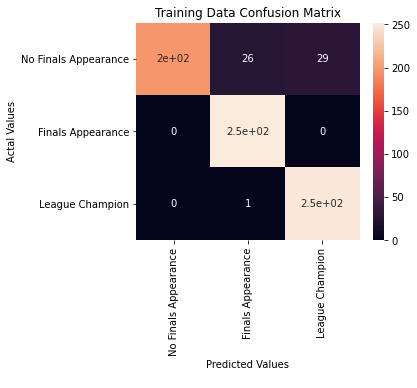

Accuracy: 0.9259259259259259
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.88       252
           1       0.90      1.00      0.95       252
           2       0.90      1.00      0.94       252

    accuracy                           0.93       756
   macro avg       0.93      0.93      0.92       756
weighted avg       0.93      0.93      0.92       756



C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [59]:
knn_model = KNeighborsClassifier(n_neighbors=6)  # You can choose the number of neighbors (e.g., 3)
evaluate_model_classification(knn_model, x_train, x_test, y_train, y_test)

## Naive Bayes

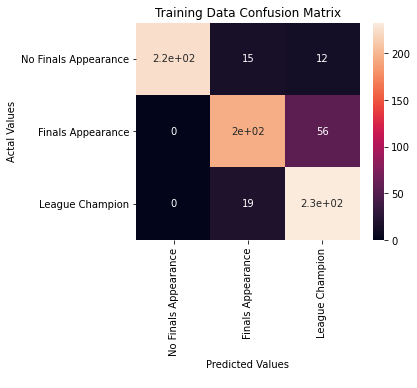

Accuracy: 0.8650793650793651
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94       252
           1       0.85      0.78      0.81       252
           2       0.77      0.92      0.84       252

    accuracy                           0.87       756
   macro avg       0.88      0.87      0.87       756
weighted avg       0.88      0.87      0.87       756



C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [60]:
nb_model = GaussianNB()
evaluate_model_classification(nb_model, x_train, x_test, y_train, y_test)

## Decision Tree

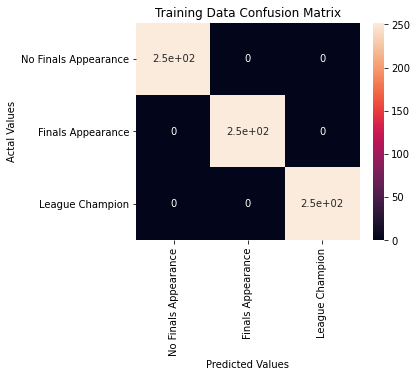

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       252
           2       1.00      1.00      1.00       252

    accuracy                           1.00       756
   macro avg       1.00      1.00      1.00       756
weighted avg       1.00      1.00      1.00       756

                   TEAM
9  Los Angeles Clippers
               TEAM
12  Milwaukee Bucks


C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [61]:
tree_model = DecisionTreeClassifier(random_state=42)
evaluate_model_classification(tree_model, x_train, x_test, y_train, y_test)

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


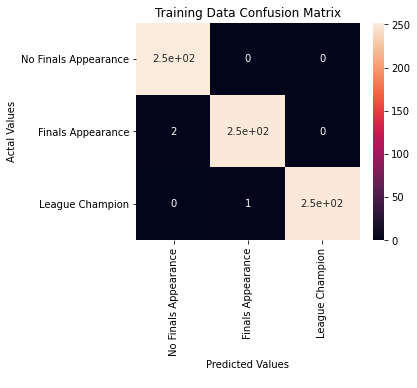

Accuracy: 0.996031746031746
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       252
           1       1.00      0.99      0.99       252
           2       1.00      1.00      1.00       252

    accuracy                           1.00       756
   macro avg       1.00      1.00      1.00       756
weighted avg       1.00      1.00      1.00       756

             TEAM
1  Boston Celtics
                   TEAM
9  Los Angeles Clippers
               TEAM
12  Milwaukee Bucks


C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [62]:
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Create the grid search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


# Get the best model
best_model = grid_search.best_estimator_
evaluate_model_classification(best_model, x_train, x_test, y_train, y_test)

# Simulation

In [64]:
team_count_dict = {}

for _ in range(1000):
    
    x_train = merged_df.drop(["TEAM", "NBA_FINALS_APPEARANCE","YEAR", "GP", "PO_WINS", "PO_LOSSES"], axis = 1)
    y_train = merged_df["NBA_FINALS_APPEARANCE"]
    x_test = merged_2024_df.drop(["TEAM", "NBA_FINALS_APPEARANCE","YEAR", "GP", "PO_WINS", "PO_LOSSES"], axis = 1)
    y_test = merged_2024_df["NBA_FINALS_APPEARANCE"]

    x_train, y_train = smt.fit_resample(x_train.values, y_train)

    # Create the grid search
    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    pred = best_model.predict(x_test)

    # Store the teams with a prediction of 1 in the dictionary
    for i in range(len(pred)):
        if pred[i] == 1 or pred[i] == 2:
            team_name = merged_2024_df.iloc[i]["TEAM"]
            if team_name in team_count_dict:
                team_count_dict[team_name] += 1
            else:
                team_count_dict[team_name] = 1

C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\adity\OneDrive\Documents\A

Denver Nuggets: 2 times
Milwaukee Bucks: 640 times
Philadelphia 76ers: 1 times
Oklahoma City Thunder: 1 times
Los Angeles Clippers: 413 times
Dallas Mavericks: 304 times
Miami Heat: 217 times
Boston Celtics: 378 times
Minnesota Timberwolves: 216 times


C:\Users\adity\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [65]:
# Print the results
for team, count in team_count_dict.items():
    print(f"{team}: {count} times")

Denver Nuggets: 2 times
Milwaukee Bucks: 640 times
Philadelphia 76ers: 1 times
Oklahoma City Thunder: 1 times
Los Angeles Clippers: 413 times
Dallas Mavericks: 304 times
Miami Heat: 217 times
Boston Celtics: 378 times
Minnesota Timberwolves: 216 times
